## Práctica I. Mejoramiento de contraste en imágenes médicas.
## Tópiocs selectos de algortimos bioinspirados.
## Grupo: 7BM1.
## Equipo: I.
## Integrantes
1.   Gómez Rodríguez Sebastian
2.   Juárez Solano Juan Martin
3.   Loeza Caudillo Uriel
4.   Miguel Martínez Ángel Gabriel





## Algoritmo Genético  

Este algoritmo está compuesto de la siguiente forma:  

1. Se genera la población inicial, para eso se generó la función `crear_poblacion`, que se asegura de generar valores aleatorios para las variables dentro de los límites establecidos.  
   La matriz que contiene a la población es creada fuera del ciclo para que pueda ser sustituida en cada generación.  

2. Para la evaluación se creó la función `evaluar`, que evalúa cada individuo en la función objetivo y agrega la aptitud a la última columna de la matriz de la población.  

En este punto se empieza la iteración:  

3. Se ordena la población por su aptitud, así se obtiene el mejor individuo.  
   Se crea una matriz de padres del tamaño de la población.  

4. Se creó la función `torneo` para hacer la selección de padres, la cual se hace por torneo determinista de dos individuos, llenando la matriz de padres.  
   Se crea una matriz de hijos para que sea llenada después.  

5. Se creó la función `cruza`, que llena una matriz con los hijos después de hacer la cruza por SBX. Aquí se llena la matriz de hijos.  

6. Se creó la función `mutacion`, que modifica las variables de los hijos por mutación SBX.  

7. Se vuelve a evaluar a los hijos para así obtener su aptitud, después se pasan todos a la nueva población, pero se selecciona uno aleatorio y es reemplazado por el mejor individuo de la generación anterior.  

Todas las funciones definidas son invocadas dentro de la función principal que implementa el algoritmo genético. Esta función se encarga de ejecutar el proceso evolutivo y devolver el mejor valor encontrado en la última generación.

In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from skimage.color import rgb2gray
import pandas as pd


def std_imagen(imagen):
    return np.std(imagen)

def sigmoid(x, alpha, delta):
    return 1 / (1 + np.exp(-alpha * (x - delta)))

def normalize_image(img):
    min_val = img.min()
    max_val = img.max()
    return (img - min_val) / (max_val - min_val) if max_val > min_val else img


def calcular_entropia(imagen):
    histograma, _ = np.histogram(imagen, bins=256, range=(0.0, 1.0), density=True)

    entropia = entropy(histograma, base=2)

    return entropia

def crear_p(tam_p,n_var, lim_s, lim_inf):

  poblacion = np.zeros((tam_p, n_var+1))
  for i in range(tam_p):
    for j in range(n_var):
      poblacion[i, j] = lim_inf[j] + (lim_s[j] - lim_inf[j]) * np.random.rand()

  return poblacion


def eval(poblacion, f, tam_p, n_var, imagen):
  imagen = plt.imread(imagen).astype(np.float64)
  imagen = rgb2gray(imagen)
  imagen = normalize_image(imagen)
  for i in range(tam_p):
    x = poblacion[i, :n_var]
    imagen_modificada = sigmoid(imagen, x[0], x[1])
    evaluacion = -f(imagen_modificada)
    poblacion[i][n_var] = evaluacion

def torneo(tam_p, poblacion, padres ):
   for i in range(tam_p):
      padre_1 = poblacion[np.random.randint(0, tam_p), :]
      padre_2 = poblacion[np.random.randint(0, tam_p), :]

      if padre_1[2] <  padre_2[2]:
        padres[i, :] = padre_1
      else:
        padres[i, :] = padre_2


def cruza(poblacion, padres, tam_p, prob_cruza, hijos, n_var, nc, lim_s, lim_inf):
    for i in range(0, tam_p, 2):
        padre_1 = padres[i, :]
        padre_2 = padres[i+1, :]
        if np.random.rand() < prob_cruza:
            for j in range(n_var):
                # Ordenar los genes para que x1 <= x2
                x1 = min(padre_1[j], padre_2[j])
                x2 = max(padre_1[j], padre_2[j])

                if abs(x2 - x1) > 1e-14:
                    u = np.random.rand()  # número aleatorio para la variable j
                    if u <= 0.5:
                        beta_q = (2 * u) ** (1.0 / (nc + 1))
                    else:
                        beta_q = (1 / (2 * (1 - u))) ** (1.0 / (nc + 1))
                    child1 = 0.5 * ((x1 + x2) - beta_q * (x2 - x1))
                    child2 = 0.5 * ((x1 + x2) + beta_q * (x2 - x1))
                else:
                    child1 = x1
                    child2 = x2

                # Asignar descendientes y asegurar límites
                hijos[i, j] = np.clip(child1, lim_inf[j], lim_s[j])
                hijos[i+1, j] = np.clip(child2, lim_inf[j], lim_s[j])
        else:
            hijos[i, :] = padre_1
            hijos[i+1, :] = padre_2


    else:
      hijos[i, :] = padre_1
      hijos[i+1, :] = padre_2



def mutacion(hijos, tam_p, prob_mut, n_var, lim_s, lim_inf, nm):
    for i in range(tam_p):
        for j in range(n_var):
            if np.random.rand() < prob_mut:
                y = hijos[i, j]
                lower = lim_inf[j]
                upper = lim_s[j]
                # Evitar división por cero
                if upper - lower > 1e-14:
                    delta_i = (y - lower) / (upper - lower)
                    r = np.random.rand()
                    if r < 0.5:
                        delta_q = (2 * r + (1 - 2 * r) * (1 - delta_i) ** (nm + 1)) ** (1.0 / (nm + 1)) - 1
                    else:
                        delta_q = 1 - (2 * (1 - r) + 2 * (r - 0.5) * (delta_i) ** (nm + 1)) ** (1.0 / (nm + 1))
                    y = y + delta_q * (upper - lower)
                hijos[i, j] = np.clip(y, lower, upper)


def algoritmo_genetico(tam_p, nun_gen, prob_cruza, prob_mut, n_var, lim_s, lim_inf,f, nc,nm, imagen):
  poblacion = crear_p(tam_p,n_var,lim_s,lim_inf)
  eval(poblacion, f,tam_p, n_var, imagen)
  #print("Poblacion inicial")
  #pprint(poblacion)

  for i in range(nun_gen):
    poblacion = poblacion[poblacion[:, n_var].argsort()]
    mejor_ind = poblacion[0]
    #print(f"Mejor individuo en la generacion {i+1}: {mejor_ind}")

    padres = np.zeros((tam_p, n_var+1))

    torneo(tam_p, poblacion, padres)
    #print("Padres")
    #pprint(padres)

    hijos = np.zeros((tam_p, n_var+1))
    cruza(poblacion, padres, tam_p, prob_cruza, hijos, n_var, nc, lim_s, lim_inf)
    mutacion(hijos, tam_p, prob_mut, n_var, lim_s, lim_inf,nm)
    #print("Hijos")
    #pprint(hijos)

    eval(hijos, f, tam_p, n_var, imagen)
    #print("Evaluacion de hijos")
    #pprint(hijos)

    poblacion = hijos
    poblacion[np.random.randint(0, tam_p), :] = mejor_ind
    #print("Poblacion final de la generacion")
    #pprint(poblacion)
  poblacion = poblacion[poblacion[:, n_var].argsort()]
  mejor_ind = poblacion[0]
  return mejor_ind[:n_var], mejor_ind[-1]



# Función para realizar grid search
def grid_search(param_grid, f, lim_s, lim_inf, n_var, imagen):
    best_score = float('inf')
    best_params = None


    for t_p in param_grid['t_p']:
        for n_g in param_grid['n_g']:
            for p_c in param_grid['p_c']:
                for p_m in param_grid['p_m']:
                    for nc in param_grid['nc']:
                        for nm in param_grid['nm']:
                            var, resultado = algoritmo_genetico(t_p, n_g, p_c, p_m, n_var, lim_s, lim_inf, f, nc, nm, imagen)

                            if resultado < best_score:
                                best_score = resultado
                                best_params = (t_p, n_g, p_c, p_m, nc, nm)

    return best_params, best_score

In [ ]:
def encontrar_mejor(f, imagen):

    n_var = 2
    media = 10
    desviacion = 2
    lim_s = [10,1] #alpha/delta
    lim_inf = [0,0]

    param_grid = {
        't_p': [40],  # Tamaño de la población
        'n_g': [10],  # Número de generaciones
        'p_c': [0.7, 0.8],  # Probabilidad de cruce
        'p_m': [0.2, 0.3],  # Probabilidad de mutación
        'nc': [1, 2, 5, 7],  # Parámetro de cruce
        'nm': [1, 2, 5, 7],  # Parámetro de mutación
    }

    best_params, best_score = grid_search(param_grid, f, lim_s, lim_inf, n_var, imagen)

    print("Mejores parámetros encontrados:")
    print(best_params)
    print("Mejor resultado encontrado:")
    print(best_score)


    t_p, n_g, p_c, p_m, nc, nm = best_params
    n_g = 200
    soluciones = np.zeros(10)
    variables_finales = []

    print("Ejecutando 10 veces...")

    for i in range(10):
      variables, soluciones[i] = algoritmo_genetico(t_p, n_g, p_c, p_m, n_var, lim_s, lim_inf, f, nc, nm, imagen)
      variables_finales.append(variables)

    print("Soluciones encontradas:")
    print(soluciones)
    print(variables_finales)



    mediana = np.median(soluciones)
    desviacion_muestral = np.std(soluciones, ddof=1)
    desviacion_poblacional = np.std(soluciones, ddof=0)
    mejor = np.min(soluciones)
    peor = np.max(soluciones)
    indice_mejor = np.argmin(soluciones)
    variables_mejor = variables_finales[indice_mejor]
    datos = {
        "Métrica": ["Mejor", "Peor", "Mediana", "Desv. Est. Muestral", "Desv. Est. Poblacional"],
        "Valor": [mejor, peor, mediana, desviacion_muestral, desviacion_poblacional]
    }

    tabla = pd.DataFrame(datos)
    print(tabla)

    print(f"Variables de la mejor solucion encontrada: {variables_mejor}")

    # Cargar la imagen en formato flotante normalizado
    imagen = plt.imread(imagen).astype(np.float64) / 255.0

    # Convertir a escala de grises
    imagen_g = rgb2gray(imagen)
    imagen_g = normalize_image(imagen_g)

    # Aplicar transformación sigmoide
    imagen_transformada_g = sigmoid(imagen_g, variables_mejor[0], variables_mejor[1])
    imagen_transformada_g = normalize_image(imagen_transformada_g)

    # Ajustar contraste sin perder los colores originales
    imagen_transformada = imagen * (imagen_transformada_g[..., np.newaxis] / (imagen_g[..., np.newaxis] + 1e-8))

    # Graficar la imagen original y la transformada
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(imagen)
    axs[0].set_title("Imagen Original")
    axs[0].axis("off")

    axs[1].imshow(imagen_transformada)
    axs[1].set_title("Imagen Transformada con Nuevo Contraste")
    axs[1].axis("off")

    plt.show()

    # Calcular entropía
    entropia_original = calcular_entropia(imagen)
    entropia_transformada = calcular_entropia(imagen_transformada)

##Dental Caries
###Algoritmo genetico por entropia



Mejores parámetros encontrados:
(40, 10, 0.8, 0.2, 2, 5)
Mejor resultado encontrado:
-7.7794884465193
Ejecutando 10 veces...


Soluciones encontradas:
[-7.77967593 -7.77968378 -7.77967531 -7.77973854 -7.77974772 -7.77974394
 -7.77970774 -7.77974513 -7.77970613 -7.77968378]
[array([9.9993861 , 0.57578817]), array([9.99933172, 0.57578887]), array([9.99935765, 0.57578833]), array([9.99896552, 0.57235277]), array([9.99853125, 0.57235483]), array([9.99895677, 0.57235302]), array([9.99949246, 0.57235177]), array([9.9989822 , 0.57235306]), array([9.99957355, 0.57235042]), array([9.99932805, 0.57578887])]
                  Métrica     Valor
0                   Mejor -7.779748
1                    Peor -7.779675
2                 Mediana -7.779707
3     Desv. Est. Muestral  0.000031
4  Desv. Est. Poblacional  0.000029
Variables de la mejor solucion encontrada: [9.99853125 0.57235483]


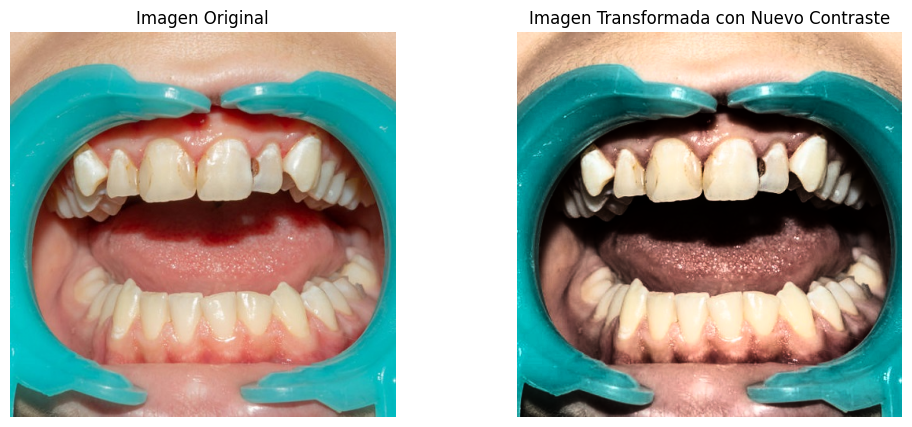

In [ ]:
encontrar_mejor(calcular_entropia, 'Dental Caries.jpg')

###Algoritmo genetico por desviacion estandar

Mejores parámetros encontrados:
(40, 10, 0.7, 0.2, 2, 1)
Mejor resultado encontrado:
-0.29127858449535504
Ejecutando 10 veces...


Soluciones encontradas:
[-0.29127858 -0.29127858 -0.29127858 -0.29127858 -0.29127858 -0.29127858
 -0.29127858 -0.29127858 -0.29127858 -0.29127858]
[array([10.        ,  0.51607364]), array([10.        ,  0.51607363]), array([10.        ,  0.51607363]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364]), array([10.        ,  0.51607364])]
                  Métrica         Valor
0                   Mejor -2.912786e-01
1                    Peor -2.912786e-01
2                 Mediana -2.912786e-01
3     Desv. Est. Muestral  5.233642e-17
4  Desv. Est. Poblacional  4.965068e-17
Variables de la mejor solucion encontrada: [10.          0.51607364]


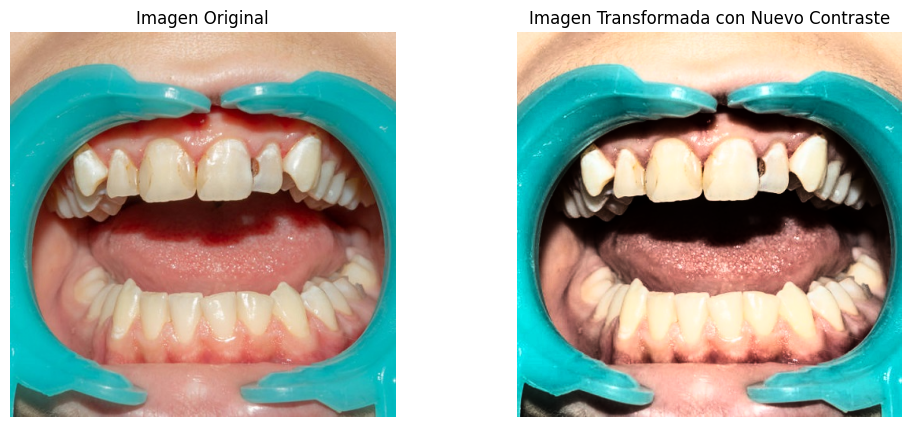

In [ ]:
encontrar_mejor(std_imagen, 'Dental Caries.jpg')

##Lisch nodules 2
###Por entropia


Mejores parámetros encontrados:
(40, 10, 0.7, 0.2, 2, 5)
Mejor resultado encontrado:
-7.710399521925403
Ejecutando 10 veces...


Soluciones encontradas:
[-7.7107488  -7.7105104  -7.7105926  -7.71050469 -7.71053875 -7.71060921
 -7.71077787 -7.71078284 -7.71058045 -7.71023678]
[array([7.55499259, 0.56098436]), array([7.67912886, 0.55699485]), array([7.54928307, 0.56076594]), array([7.59955591, 0.55813662]), array([7.59914734, 0.55814001]), array([7.59930246, 0.55814707]), array([7.55401362, 0.56103683]), array([7.55736769, 0.561159  ]), array([7.59893707, 0.55812887]), array([7.59317354, 0.56291665])]
                  Métrica     Valor
0                   Mejor -7.710783
1                    Peor -7.710237
2                 Mediana -7.710587
3     Desv. Est. Muestral  0.000163
4  Desv. Est. Poblacional  0.000155
Variables de la mejor solucion encontrada: [7.55736769 0.561159  ]


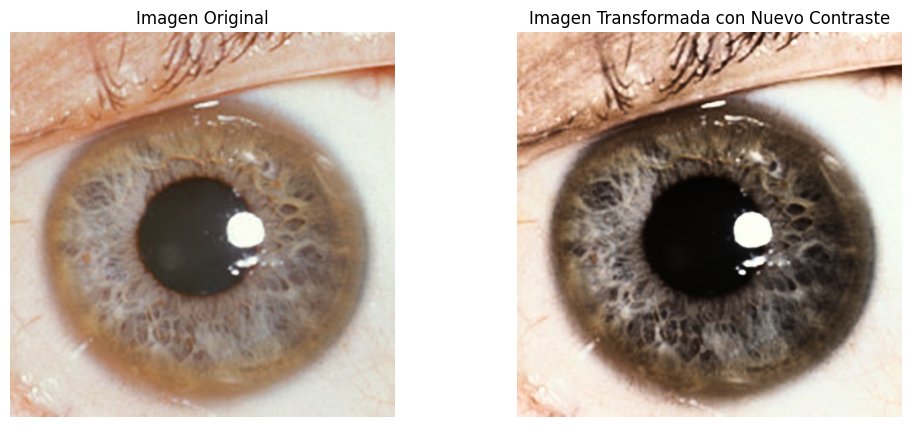

In [ ]:
encontrar_mejor(calcular_entropia, 'Lisch nodules 2.jpg')

###Por desviacion estandar

Mejores parámetros encontrados:
(40, 10, 0.8, 0.2, 1, 2)
Mejor resultado encontrado:
-0.34636449642817235
Ejecutando 10 veces...


Soluciones encontradas:
[-0.3463645 -0.3463645 -0.3463645 -0.3463645 -0.3463645 -0.3463645
 -0.3463645 -0.3463645 -0.3463645 -0.3463645]
[array([10.        ,  0.58060212]), array([10.        ,  0.58060213]), array([10.        ,  0.58060218]), array([10.        ,  0.58060218]), array([10.        ,  0.58060218]), array([10.        ,  0.58060219]), array([10.        ,  0.58060216]), array([10.        ,  0.58060218]), array([10.        ,  0.58060218]), array([10.        ,  0.58060204])]
                  Métrica         Valor
0                   Mejor -3.463645e-01
1                    Peor -3.463645e-01
2                 Mediana -3.463645e-01
3     Desv. Est. Muestral  1.271230e-14
4  Desv. Est. Poblacional  1.205994e-14
Variables de la mejor solucion encontrada: [10.          0.58060218]


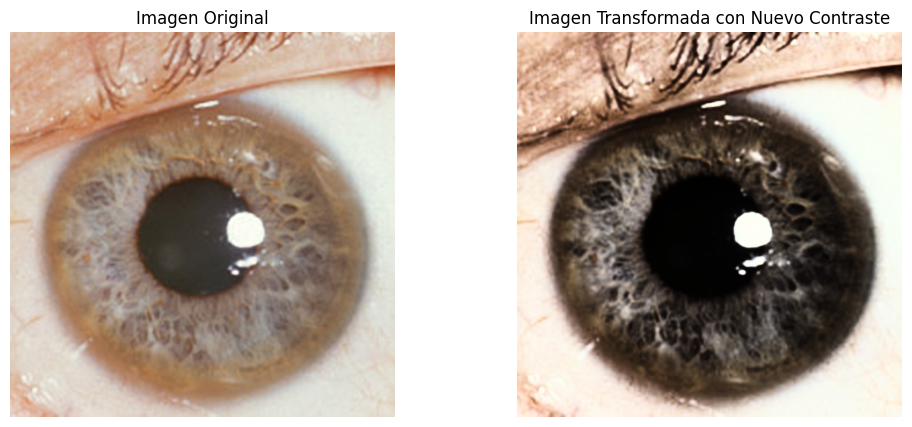

In [ ]:
encontrar_mejor(std_imagen, 'Lisch nodules 2.jpg')